In [17]:
import sys, os
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
import pickle
from pathlib import Path



In [19]:
ROOT = Path.cwd().parents[0]
model_name="xgboost_panel_with_feat"
FEATURE_LIST_FILE = ROOT / "datamodel" / f"{model_name}.pkl"
MODEL_FILE = ROOT / "datamodel" / f"{model_name}.pkl"
RESULT_FILE = ROOT / 'datamodel' / f"{model_name}_pred.csv"
ENCODER_FILE  = ROOT / "datamodel" / f"{model_name}_label_enc.pkl"







In [21]:
# Reload categorical encoders from file
with open(ENCODER_FILE, 'rb') as f:
    categorical_encoders = pickle.load(f)

# Reload model from file
with open(MODEL_FILE, 'rb') as f:
    model = pickle.load(f)

# Reload features from file
with open(FEATURE_LIST_FILE, 'rb') as f:
    features = pickle.load(f)


In [71]:
df=pd.read_csv(RESULT_FILE)

In [23]:
df.columns

Index(['ID_UEV', 'month', 'LATITUDE', 'LONGITUDE', 'MUNICIPALITE',
       'ETAGE_HORS_SOL', 'NOMBRE_LOGEMENT', 'AGE_BATIMENT', 'CODE_UTILISATION',
       'CATEGORIE_UEF', 'SUPERFICIE_TERRAIN', 'SUPERFICIE_BATIMENT',
       'NO_ARROND_ILE_CUM', 'RATIO_SURFACE', 'DENSITE_LOGEMENT',
       'HAS_MULTIPLE_LOGEMENTS', 'FIRE_FREQUENCY_ZONE', 'FIRE_RATE_ZONE',
       'FIRE_COUNT_LAST_YEAR_ZONE', 'BUILDING_COUNT', 'FIRE_RATE_ZONE_NORM',
       'FIRE_COUNT_LAST_YEAR_ZONE_NORM', 'HAS_FIRE_THIS_MONTH', 'fire_last_1m',
       'fire_last_2m', 'fire_last_3m', 'fire_cumcount', 'fire_rolling_3m',
       'fire_rolling_6m', 'fire_rolling_12m', 'has_fire_last_month',
       'months_since_last_fire', 'month_num', 'year', 'predicted_result',
       'predicted_proba', 'target'],
      dtype='object')

In [24]:
pred_year=2024
top_predictions = df[df['year']==pred_year].sort_values(['predicted_proba', 'month_num'], 
                                        ascending=[False, False]) \
                             .groupby('ID_UEV') \
                             .first() \
                             .reset_index()
    
# Sort by probability and select top 7500
result = top_predictions.sort_values('predicted_proba', 
                                       ascending=False) \
                           .head(7500)

prioritization_list = result.merge(top_predictions)
actual_fires=df[(df['year']==pred_year) & (df['target']==1)][['ID_UEV']].drop_duplicates().copy(deep=True)
actual_fires['actual_fire']=1
print(actual_fires)

result=result.merge(actual_fires,how='left')
result['actual_fire'].fillna(0,inplace=True)
result['actual_fire'].value_counts()


          ID_UEV  actual_fire
73       1000038            1
85       1000039            1
109      1000041            1
133      1000043            1
157      1000045            1
...          ...          ...
3724275  5307816            1
3724287  5307817            1
3724299  5307818            1
3724311  5307819            1
3724637  5308940            1

[42788 rows x 2 columns]


actual_fire
0.0    4139
1.0    3361
Name: count, dtype: int64

In [25]:
np.random.seed(42) #(for repeatability)

random_pick=pd.DataFrame()
#randomly pick 7500 buildings
random_pick['ID_UEV']=np.random.choice(df['ID_UEV'].unique(),size=7500)
random_pick.head()
#merge with actual fires
random_pick=random_pick.merge(actual_fires,how='left')
random_pick['actual_fire']=random_pick['actual_fire'].fillna(0)
random_pick['actual_fire'].value_counts()
int(random_pick['actual_fire'].value_counts()[1])



1058

In [26]:
print("predicted high probability value with actual fires")
result_df=pd.DataFrame()
result_df['Method']=['Random pick','Highest predicted risk']
result_df['Actual fire*']=[int(random_pick['actual_fire'].value_counts()[1]),int(result['actual_fire'].value_counts()[1])]
result_df['Precision@K']=result_df['Actual fire*'].apply(lambda x:f"{x/7500:.2%}")
result_df

predicted high probability value with actual fires


,Method,Actual fire*,Precision@K
0,Random pick,1058,14.11%
1,Highest predicted risk,3361,44.81%


In [27]:
len(actual_fires['ID_UEV'])

42788

In [28]:
len(df['ID_UEV'].unique())

310387

In [29]:
len(df[(df['year']==pred_year) & (df['target']==1)][['ID_UEV']])

50239

In [30]:
len(df[(df['year']==2024) & (df['target'])]['ID_UEV'].unique())

42788

In [31]:
#this method is extracting highest risks in predicted set vs random but may return multiple times the same building
# so it's probably best not to use it

print("Random pick: ")
print(df.iloc[np.random.choice(df.index.to_list(),size=7500)]['target'].value_counts())
print("Predicted :")
print(df.nlargest(7500,columns='predicted_proba')['target'].value_counts())

Random pick: 
target
0    7396
1     104
Name: count, dtype: int64
Predicted :
target
0    7004
1     496
Name: count, dtype: int64


In [33]:
#feature_names=list(set(list(df.columns)) -set(['target,predicted_result','predicted_proba']))
importances = model.feature_importances_
print(importances) 
print(len(importances),len(features))
print(features)
feature_imp_df = pd.DataFrame({'Feature': features, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False) 
print(feature_imp_df)


[0.06638228 0.13732873 0.37997583 0.05488338 0.11545169 0.09035521
 0.06177976 0.04455103 0.04929203]


TypeError: object of type 'XGBClassifier' has no len()

Evaluating precision@k for different k values

In [34]:
for k in [1000, 2500, 5000, 7500, 10000, 15000]:
    top_k = top_predictions.sort_values('predicted_proba', ascending=False).head(k)
    top_k = top_k.merge(actual_fires, how='left')
    top_k['actual_fire'] = top_k['actual_fire'].fillna(0)
    precision = top_k['actual_fire'].mean()
    print(f'Precision@{k}: {precision:.2%}')


Precision@1000: 43.20%
Precision@2500: 45.28%
Precision@5000: 46.52%
Precision@7500: 44.81%
Precision@10000: 44.82%
Precision@15000: 41.81%


Precision@K for Fire Predictions for k=1000 to 15000

Precision@1000: 43.20%
Precision@2500: 45.28%
Precision@5000: 46.52%
Precision@7500: 44.81%
Precision@10000: 44.82%
Precision@15000: 41.81%


C:\Users\mirei\AppData\Local\Temp\ipykernel_32716\2397731355.py:24: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  plt.tight_layout()
c:\ProgramData\Anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


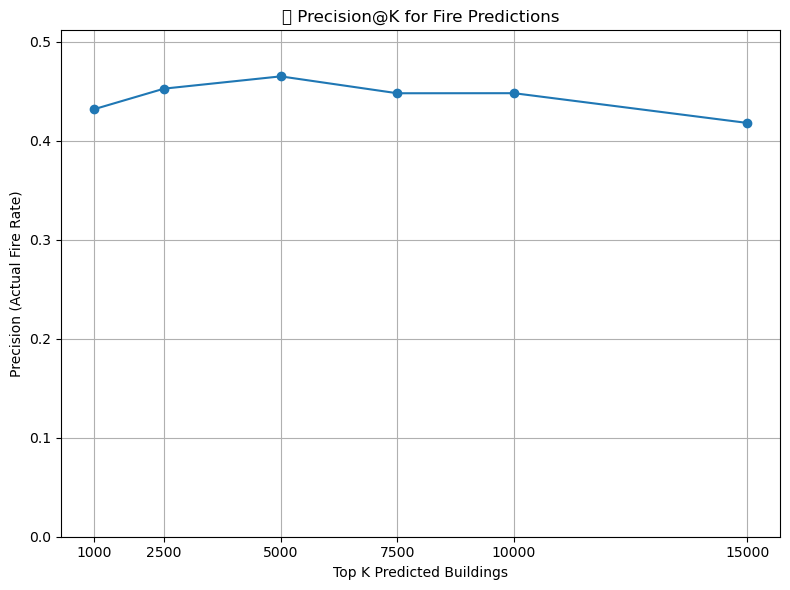

In [35]:
import matplotlib.pyplot as plt

# Store values for plotting
k_values = [1000, 2500, 5000, 7500, 10000, 15000]
precision_values = []

for k in k_values:
    top_k = top_predictions.sort_values('predicted_proba', ascending=False).head(k)
    top_k = top_k.merge(actual_fires, how='left')
    top_k['actual_fire'] = top_k['actual_fire'].fillna(0)
    precision = top_k['actual_fire'].mean()
    precision_values.append(precision)
    print(f'Precision@{k}: {precision:.2%}')

# 📊 Plot Precision@K
plt.figure(figsize=(8, 6))
plt.plot(k_values, precision_values, marker='o')
plt.xlabel("Top K Predicted Buildings")
plt.ylabel("Precision (Actual Fire Rate)")
plt.title("🔥 Precision@K for Fire Predictions")
plt.grid(True)
plt.xticks(k_values)
plt.ylim(0, max(precision_values) * 1.1)
plt.tight_layout()
plt.show()


The Precision@K for Fire Predictions shows a clear pattern:

Precision is highest for top 5000 predictions (~47%).

As you increase k to include more buildings (7500–15000), the precision decreases slightly.

Add Baseline Fire Rate (Average)

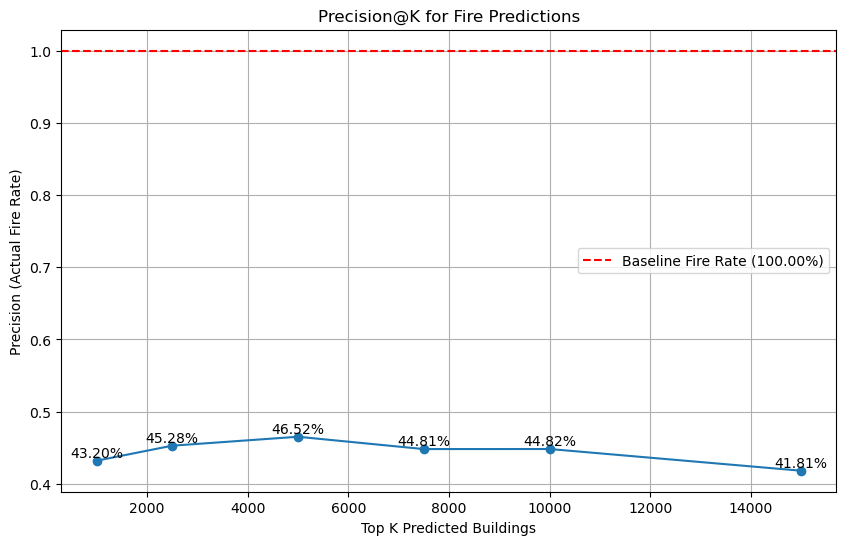

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # width, height in inches
plt.plot(k_values, precision_values, marker='o')
plt.title("Precision@K for Fire Predictions")
plt.xlabel("Top K Predicted Buildings")
plt.ylabel("Precision (Actual Fire Rate)")

#  Add baseline line
baseline = actual_fires['actual_fire'].mean()
plt.axhline(baseline, color='red', linestyle='--', label=f'Baseline Fire Rate ({baseline:.2%})')

# Annotate precision values
for x, y in zip(k_values, precision_values):
    plt.text(x, y + 0.005, f'{y:.2%}', ha='center')

plt.legend()
plt.grid(True)

#  Save at normal resolution
plt.savefig("precision_at_k.png", dpi=150, bbox_inches='tight')
plt.show()


C:\Users\mirei\AppData\Local\Temp\ipykernel_32716\4131154533.py:44: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  plt.tight_layout()
c:\ProgramData\Anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


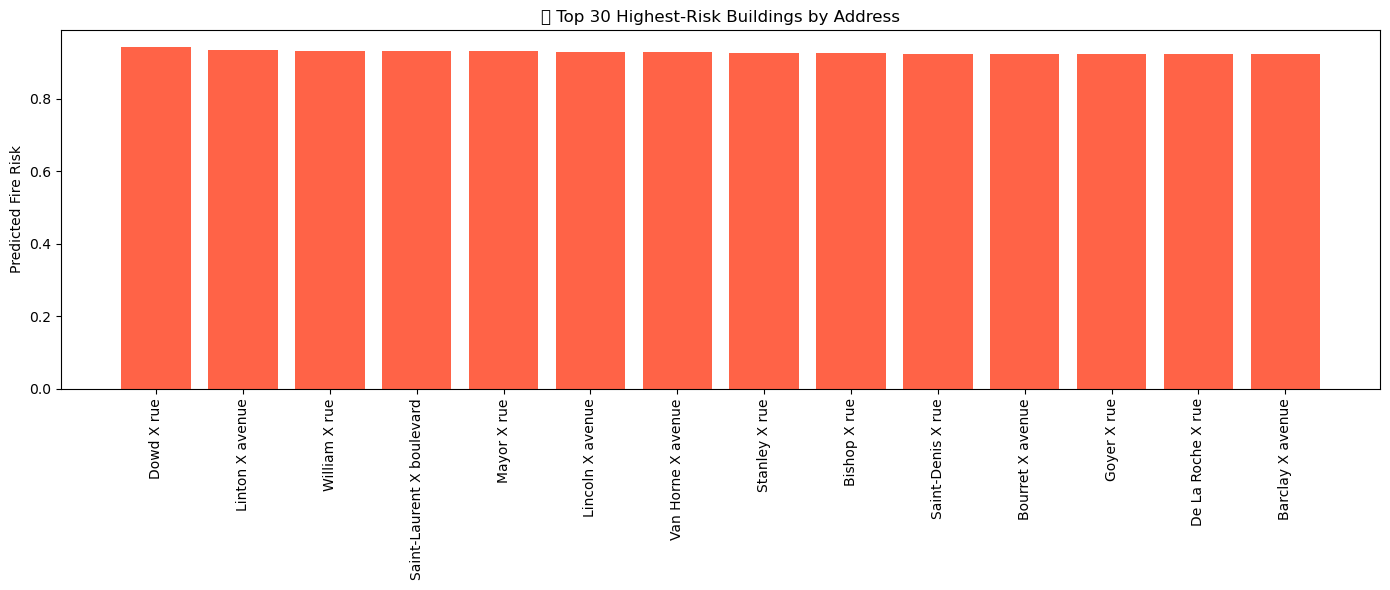

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# 📁 Load only needed columns
ROOT = Path.cwd().parents[0]
PRED_FILE = ROOT / "datamodel" / "xgboost_panel_with_feat_pred.csv"
ADDR_FILE = ROOT / "datasets" / "cleaned" / "adresses.csv"

df = pd.read_csv(PRED_FILE, usecols=["LONGITUDE", "LATITUDE", "predicted_proba"])
address_df = pd.read_csv(ADDR_FILE, usecols=["LONGITUDE", "LATITUDE", "SPECIFIQUE", "ORIENTATION", "GENERIQUE"])

# 🏷️ Build full address
address_df["ADRESSE"] = (
    address_df["SPECIFIQUE"].astype(str).str.strip() + " " +
    address_df["ORIENTATION"].fillna("").astype(str).str.strip() + " " +
    address_df["GENERIQUE"].astype(str).str.strip()
).str.replace("  ", " ").str.strip()

# 🔁 Merge and clean
df = df.merge(address_df[["LONGITUDE", "LATITUDE", "ADRESSE"]],
              on=["LONGITUDE", "LATITUDE"], how="left")
df = df.dropna(subset=["ADRESSE", "predicted_proba"])

# 🔝 Get top 30
top_buildings = df.sort_values("predicted_proba", ascending=False).head(30)

# 🔍 Plot with annotations
plt.figure(figsize=(10, 8))
bars = plt.barh(top_buildings["ADRESSE"], top_buildings["predicted_proba"], color="tomato")
plt.xlabel("Predicted Fire Risk")
plt.title("🔥 Top 30 Highest-Risk Buildings by Address")

# Add percentage labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2,
             f"{width:.2%}", va='center', fontsize=9)

plt.gca().invert_yaxis()  # highest risk on top
plt.tight_layout()
plt.show()
